### 2. Γραμμικός Προγραμματισμός

In [1]:
from scipy import optimize
import numpy as np

In [2]:

def intersect_constraints(c,A, b):
    """
    Convert Ax <= b to Ax - s <= 0, then eliminate x1 from the system of constraints,
    using the first constraint to express x1 in terms of x2.
    
    :param constraints: List of constraints, where each constraint
                        is a list [a1, a2] representing a1*x1 + a2*x2
    :param b: List of right-hand side values for each constraint
    :return: New list of constraints in terms of x2 only, and new right-hand side values
    """
    idx = 0
    for i in range(A[-1].shape[0]):
        if A[-1][i] != 0:
           idx = i
           break
    new_coeffs = np.delete(A, idx, axis=1)[-1]*-1
    new_c = c[idx+1:]*A[-1,idx]+ new_coeffs*c[idx]
    new_of_constant = c[idx]*b[-1]
    constant = b[-1]
    
    new_A = np.delete(A[:-1],idx,axis=1)*A[-1,idx] + np.outer(A[:-1,idx], new_coeffs)
    new_b = b[:-1]*A[-1,idx] - constant*A[:-1,idx]
    return idx, new_c, new_A, new_b, new_of_constant

In [3]:
c = np.array([-5,-12])
A = np.array([
        [1, 3],    # x1 + 3x2 <= 5
        [1, -1],   # x1 - x2 <= 3
        [-7, 3], # -7x1 + 3x2 <= -1 (rearranged from 7x1 - 3x2 >= 1)
        [4, -9], # 4x1 - 9x2 <= 35
        [3, -7], # 3x1 - 7x2 <= 32
        [-2, 5], # -2x1 + 5x2 <= 26
    ])
b = np.array([5, 3, -1, 35, 32, 26])
x_bounds = (0, None)

In [61]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import numpy as np
np.float_ = np.float64
import matplotlib.pyplot as plt
def plot_feasible_region(optimal,A=A, b=b ):
    d = np.linspace(0,16,300)
    x1,x2 = np.meshgrid(d,d)
    plt.figure(figsize=(10,10))
    feasible_region = np.logical_and.reduce([(A[i, 0] * x1 + A[i, 1] * x2 <= b[i]) for i in range(A.shape[0])])
    plt.imshow(feasible_region.astype(int) , 
                    extent=(x1.min(),x1.max(),x2.min(),x2.max()),origin="lower", cmap="Greys", alpha = 0.3);
    plt.annotate(f'({optimal[0]}, {optimal[1]})', 
                 xy=(optimal[0], optimal[1]), 
                 xytext=(optimal[0]-1.2, optimal[1] + 0.6),
                 )
    plt.plot(optimal[0], optimal[1], 'ro', label='Optimal point',zorder=999)
    x1 = np.linspace(-1000, 1000, 2000)
    for i in range(A.shape[0]):
        x2 = (b[i] - A[i,0]*x1)/A[i,1]
        # U+2212 is the unicode for the big "minus" sign
        label = f'{A[i, 0] if abs(A[i, 0]) > 1 else ""}x ' + ['\u2212', "+"][int(A[i, 1] > 0 )] + f' {abs(A[i, 1]) if abs(A[i, 1]) > 1 else ""}y <= {b[i]}'
        plt.plot(x1, x2, lw=2, label=label)
    plt.axvline(x=0, color='black', linestyle='--')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    

#### Seidel's incremental algorithm in 2D

Optimal solution: [3.5 0.5]


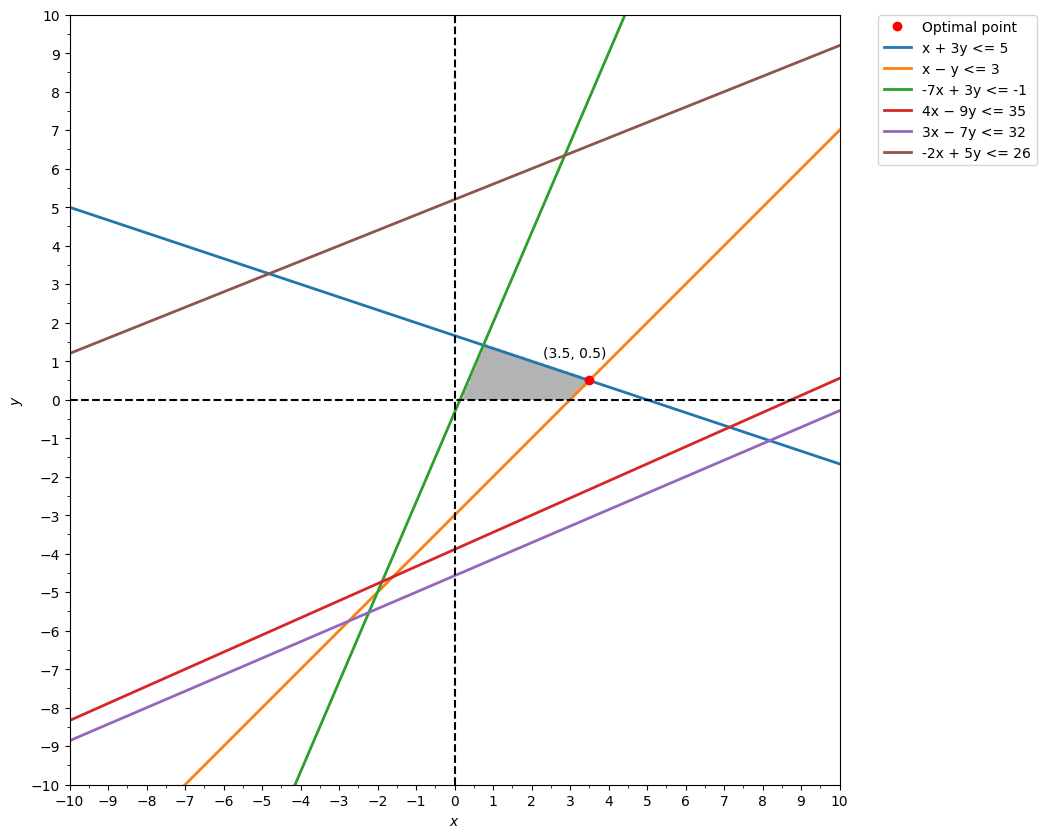

In [63]:
def seidel_2d(A, b, c, x_bounds):
    max_x = np.inf
    max_f = np.inf
    n=len(A)
    for i in range(len(A)):
        for j in range(i+1, len(A)):
            for k in range(j+1, len(A)):
                res = optimize.linprog(c, A_ub=[A[i], A[j], A[k]], b_ub=[b[i], b[j], b[k]], bounds=x_bounds)

                if res.success:
                    max_x = res.x
                    max_idcs = [i,j,k]
                    break
    H = np.array(A[max_idcs])
    bH = np.array(b[max_idcs])
    A = np.delete(A, max_idcs, axis=0)
    b = np.delete(b, max_idcs)
    x_i = max_x
    for i in range(len(A)):
        tmp = np.vstack((H, A[i]))
        tmpB = np.append(bH, b[i])
        if A[i]@x_i > b[i]:
            idx, new_c, new_A, new_b, new_of_constant = intersect_constraints(c, tmp, tmpB) #intersection with new constraint, returns new d-1 problem 
            res = optimize.linprog(new_c, A_ub=new_A, b_ub=new_b,bounds=x_bounds) # this is the same, but easier code
            # res = optimize.linprog(c, A_ub=tmp[:-1], b_ub=tmpB[:-1], A_eq=tmp[-1,np.newaxis], b_eq=tmpB[-1], bounds=x_bounds) #solve d-1 problem
            if res.success:
                # x_i = res.x #this is for the other version
                x2 = res.x
                x1 = (b[i] - np.delete(A[i],idx)*x2)/A[i,idx]
                x_i = np.append(x1, x2)
                # print(x_i)
            else:
                break
        H = tmp
        bH = tmpB
    if len(H) == n:
        status = 1
        return status, x_i
    else:
        status = 0
        return status, None
status, optimal = seidel_2d(A, b, c, x_bounds)
if status:
    print('Optimal solution:', optimal)
    plot_feasible_region(optimal)

Μια παρατήρηση που έκανα είναι ότι αντί να εκφράσω τους νέους περιορισμούς με βάση τον H_i(x*) = 0 και πάω να λύσω το d-1 πρόβλημα, μπορώ να δώσω τους ίδιους περιορισμούς στην linprog, αλλά αυτή την φορά με τον περιορισμό ότι H_i(x*) = 0. Αυτό το θεωρώ καλύτερο μιας και είναι optimized και έχει απλούστερο κώδικα, αλλά το άφησα commented out